### osu!nn #3: momentum estimator

Builds up a model to estimate the momentum - distance over time interval, from the training data.

It might be more accurate to be proportional to circle size, might implement later.

Synthesis of "momentumModel"
* rhythmData x 1
* (Audio) x 1
* (Regressor) x 1

Synthesis Time: ~5 mins

Final edit: 2018/8/16

In [8]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [9]:
root = "mapdata/";

divisor = 4;

# this is a global variable!
time_interval = 16;

In [10]:
# lst file, [TICK, TIME, NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, IS_SPINNER_END, 
#               0,    1,    2,         3,         4,          5,             6,              7,
#            SLIDING, SPINNING, MOMENTUM, ANGULAR_MOMENTUM, EX1, EX2, EX3], length MAPTICKS
#                  8,        9,       10,               11,  12,  13,  14,
# wav file, [len(snapsize), MAPTICKS, 2, fft_size//4]
def read_npz(fn):
    with np.load(fn) as data:
        wav_data = data["wav"];
        wav_data = np.swapaxes(wav_data, 2, 3);
        train_data = wav_data;
        div_source = data["lst"][:, 0];
        div_source2 = data["lst"][:, 12:15];
        div_data = np.concatenate([np.array([[int(k%4==0), int(k%4==1), int(k%4==2), int(k%4==3)] for k in div_source]), div_source2], axis=1);
        lst_data = data["lst"][:, 10:12];
        train_labels = lst_data;
    return train_data, div_data, train_labels;

def read_npz_list():
    npz_list = [];
    for file in os.listdir(root):
        if file.endswith(".npz"):
            npz_list.append(os.path.join(root, file));
    # reutnr npz_lsit;
    return npz_list;

train_glob_defined = False;
train_glob_max = 0;
train_glob_min = 0;

def prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered):
    global train_glob_defined, train_glob_max, train_glob_min;
    nonempty_labels = np.array([i for i, label in enumerate(train_labels_unfiltered) if (label[0] != 0 or label[1] != 0) and not np.isnan(label[0]) and not np.isnan(label[1]) and label[0] > -10 and label[0] < 10 and label[1] > -10 and label[1] < 10]);

    train_data = train_data_unfiltered[nonempty_labels];
    div_data = div_data_unfiltered[nonempty_labels];
    train_labels = train_labels_unfiltered[nonempty_labels];
    if not train_glob_defined:
        train_glob_max = train_labels.max(axis=0);
        train_glob_min = train_labels.min(axis=0);
        train_glob_defined = True;
    train_labels_normalized = (train_labels - train_glob_min)/(train_glob_max - train_glob_min) * 0.8 * 2 - 1;
    
    return train_data, div_data, train_labels_normalized;

def preprocess_npzs(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered):
    train_data, div_data, train_labels = prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
    
    # Make time intervals from training data
    if train_data.shape[0]%time_interval > 0:
        train_data = train_data[:-(train_data.shape[0]%time_interval)];
        div_data = div_data[:-(div_data.shape[0]%time_interval)];
        train_labels = train_labels[:-(train_labels.shape[0]%time_interval)];
    train_data2 = np.reshape(train_data, (-1, time_interval, train_data.shape[1], train_data.shape[2], train_data.shape[3]))
    div_data2 = np.reshape(div_data, (-1, time_interval, div_data.shape[1]))
    train_labels2 = np.reshape(train_labels, (-1, time_interval, train_labels.shape[1]))
    return train_data2, div_data2, train_labels2;

def get_data_shape():
    for file in os.listdir(root):
        if file.endswith(".npz"):
            train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered = read_npz(os.path.join(root, file));
            train_data, div_data, train_labels = prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
            if train_data.shape[0] == 0:
                continue;
            return train_data.shape, div_data.shape, train_labels.shape;
    print("cannot find npz!! using default shape");
    return (-1, 7, 32, 2), (-1, 7), (-1, 2);

def read_some_npzs_and_preprocess(npz_list):
    td_list = [];
    dd_list = [];
    tl_list = [];
    for fp in npz_list:
        if fp.endswith(".npz"):
            _td, _dd, _tl = read_npz(fp);
            td_list.append(_td);
            dd_list.append(_dd);
            tl_list.append(_tl);
    train_data_unfiltered = np.concatenate(td_list);
    div_data_unfiltered = np.concatenate(dd_list);
    train_labels_unfiltered = np.concatenate(tl_list);
    
    train_data2, div_data2, train_labels2 = preprocess_npzs(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
    return train_data2, div_data2, train_labels2;

def train_test_split(train_data2, div_data2, train_labels2, test_split_count=233):
    new_train_data = train_data2[:-test_split_count];
    new_div_data = div_data2[:-test_split_count];
    new_train_labels = train_labels2[:-test_split_count];
    test_data = train_data2[-test_split_count:];
    test_div_data = div_data2[-test_split_count:];
    test_labels = train_labels2[-test_split_count:];
    return (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels);

train_file_list = read_npz_list();

train_shape, div_shape, label_shape = get_data_shape();

The train_glob_max and train_glob_min parameters need to be saved and subsequently used to scale results in momentum prediction.

momentum_predictions_output = momentum_model.predict([test_data2, div_data2]);

momentum_predictions = (momentum_predictions_output.reshape(-1, 2) + 1) / 2 / 0.8 * (train_glob_max - train_glob_min) + train_glob_min;

Now build the model.

In [16]:
from tensorflow.keras.models import Model;

def build_model():
    model1 = keras.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 2),
                           data_format='channels_last'),
                           input_shape=(time_interval, train_shape[1], train_shape[2], train_shape[3])),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 3),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.LSTM(64, activation=tf.nn.tanh, return_sequences=True)
    ])
    
    input2 = keras.layers.InputLayer(input_shape=(time_interval, div_shape[1]));
    
    conc = keras.layers.concatenate([model1.output, input2.output]);
    dense1 = keras.layers.Dense(71, activation=tf.nn.tanh)(conc);
    dense2 = keras.layers.Dense(71, activation=tf.nn.relu)(dense1);
    dense3 = keras.layers.Dense(label_shape[1], activation=tf.nn.tanh)(dense2);
    
#     model2 = keras.Sequential([
#         keras.layers.Concatenate(64, activation=tf.nn.tanh),
#         keras.layers.Dense(64, activation=tf.nn.tanh),
#         keras.layers.Dense(64, activation=tf.nn.relu),
#         #    keras.layers.Reshape((4,8)),
#         #    keras.layers.Conv1D(8,2),
#         #    keras.layers.Flatten(),
#         keras.layers.Dense(6, activation=tf.nn.tanh)
#     ])

    optimizer = tf.train.RMSPropOptimizer(0.001);

    
    final_model = Model(inputs=[model1.input, input2.input], outputs=dense3);
    final_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[keras.metrics.mae])
    return final_model

model = build_model()
model.summary()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Limitless]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val MAE')
    plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    plt.show()

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_18_input (Inpu (None, 16, 7, 32, 2) 0                                            
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri (None, 16, 6, 31, 16 144         time_distributed_18_input[0][0]  
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 16, 6, 15, 16 0           time_distributed_18[0][0]        
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 16, 6, 15, 16 0           time_distributed_19[0][0]        
__________________________________________________________________________________________________
time_distr

ぐるぐる。


........

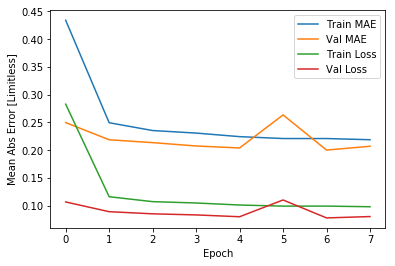


Testing set Mean Abs Error: 0.22907164660901982


In [17]:
# Don't worry, it will successfully overfit after those 16 epochs.
EPOCHS = 8

# since each map npz is about 6mb, this amounts to around 1200mb of RAM.
too_many_maps_threshold = 200
data_split_count = 160

# if there is too much data, reduce epoch count (hmm)
if len(train_file_list) >= too_many_maps_threshold:
    EPOCHS = 4

if len(train_file_list) < too_many_maps_threshold:
    train_data2, div_data2, train_labels2 = read_some_npzs_and_preprocess(train_file_list);

    # Split some test data out
    (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels) = train_test_split(train_data2, div_data2, train_labels2);

    # Store training stats
    history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=EPOCHS,
                        validation_split=0.2, verbose=0, #batch_size=477,
                        callbacks=[early_stop, PrintDot()])

    # For development! may cause bug in some environment.
#     plot_history(history)
else: # too much data! read it every turn.
    for epoch in range(EPOCHS):
        for map_batch in range(np.ceil(len(train_file_list) / data_split_count).astype(int)): # hmmmmm
            if map_batch == 0:
                train_data2, div_data2, train_labels2 = read_some_npzs_and_preprocess(train_file_list[map_batch * data_split_count : (map_batch+1) * data_split_count]);
                (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels) = train_test_split(train_data2, div_data2, train_labels2);
            else:
                new_train_data, new_div_data, new_train_labels = read_some_npzs_and_preprocess(train_file_list[map_batch * data_split_count : (map_batch+1) * data_split_count]);
            
            history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=1,
                                validation_split=0.2, verbose=0, #batch_size=477,
                                callbacks=[])
            # Manually print the dot
            print('.', end='');
        print('');

[loss, mae] = model.evaluate([test_data, test_div_data], test_labels, verbose=0)

print("\nTesting set Mean Abs Error: {}".format(mae))

In [13]:
# test_predictions = model.predict([test_data, test_div_data]).reshape((-1, time_interval, label_shape[1]))

# # print(test_predictions)
# # print(test_labels)
# # print(test_predictions - list(test_labels))
# print("Mean Abs Error: "+str(np.mean(np.abs(test_predictions - test_labels))))

Save the minmax and the model.

In [14]:
np.save("momentum_minmax", [train_glob_max, train_glob_min]);

tf.keras.models.save_model(
    model,
    "saved_rhythm_model_momentums",
    overwrite=True,
    include_optimizer=True
);

# WARNING:tensorflow:TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer
# state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will
# have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
